In [1]:
import harp
import numpy as np
from pathlib import Path
import os
import utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import signal
import copy
from datetime import datetime, timedelta

## Loading

In [2]:
# data_path = Path('/home/ikharitonov/RANCZLAB-NAS/data/ONIX/20240730_Mismatch_Experiment/MMclosed&Regular_130824/2024-08-13T12-53-01_B3M3')
# photometry_path = Path('/home/ikharitonov/RANCZLAB-NAS/data/ONIX/20240730_Mismatch_Experiment/MMclosed&Regular_130824/photometry/B3M3_MMclosed&Regular_day2/2024_08_13-14_57_35')
data_path = Path('/home/ikharitonov/RANCZLAB-NAS/data/ONIX/20240730_Mismatch_Experiment/GRAB_MMclosed&Regular_230824/2024-08-23T12-51-05_B3M7')
photometry_path = Path('/home/ikharitonov/RANCZLAB-NAS/data/ONIX/20240730_Mismatch_Experiment/GRAB_MMclosed&Regular_230824/photometry/B3M7_MMclosed&Regular_day2/2024_08_23-14_54_36')

In [3]:
streams = utils.load_registers(data_path)
print(streams[0].keys())
print(streams[1].keys())

Dataset 2024-08-23T12-51-05_B3M7 contains following registers:
H1: [32, 38, 33, 46]
H2: [42, 39]
Successfully loaded.
dict_keys(['Cam0Event(32)', 'StartCam0(38)', 'StartCam1(38)', 'StopCam0(38)', 'StopCam1(38)', 'Cam1Event(33)', 'OpticalTrackingRead0X(46)', 'OpticalTrackingRead0Y(46)', 'OpticalTrackingRead0Brightness(46)', 'OpticalTrackingRead1X(46)', 'OpticalTrackingRead1Y(46)', 'OpticalTrackingRead1Brightness(46)'])
dict_keys(['ImmediatePulses(42)', 'AnalogInput(39)'])


## Unit conversion for running

In [4]:
resolution = 12000 # counts per inch
inches_per_count = 1 / resolution
meters_per_count = 0.0254 * inches_per_count
print(meters_per_count)

dt = 0.01 # for OpticalTrackingRead0Y(46)
linear_velocity = meters_per_count / dt # meters per second per count
print(linear_velocity)

2.1166666666666666e-06
0.00021166666666666664


In [5]:
streams[0]['OpticalTrackingRead0X(46)'] * linear_velocity * 100

Time
1904-01-06 01:46:41.470240    5.461000
1904-01-06 01:46:41.480256    5.291667
1904-01-06 01:46:41.490240    5.080000
1904-01-06 01:46:41.500256    4.847167
1904-01-06 01:46:41.510240    5.143500
                                ...   
1904-01-06 02:18:41.950240    7.874000
1904-01-06 02:18:41.960256    7.768167
1904-01-06 02:18:41.970240    7.725833
1904-01-06 02:18:41.980256    7.747000
1904-01-06 02:18:41.990240    7.471833
Name: OpticalTrackingRead0X, Length: 192053, dtype: float64

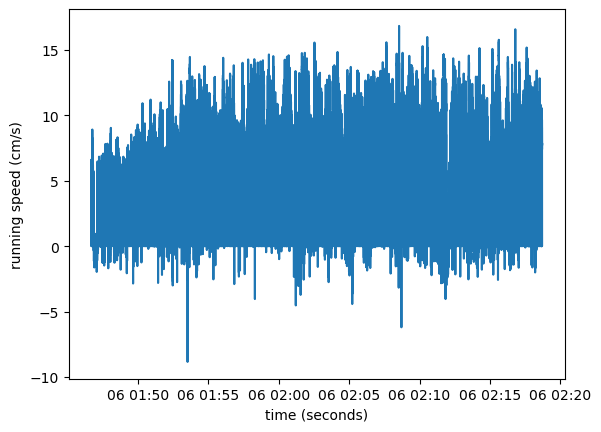

In [6]:
plt.plot(streams[0]['OpticalTrackingRead0X(46)'] * linear_velocity * 100)
plt.xlabel('time (seconds)')
plt.ylabel('running speed (cm/s)')
plt.show()

## Synchronising photometry signal

In [7]:
Fluorescence = pd.read_csv(photometry_path/'Fluorescence.csv', skiprows=1, index_col=False)
Fluorescence = Fluorescence.drop(columns='Unnamed: 5')
Fluorescence

,TimeStamp,Events,CH1-410,CH1-470,CH1-560
0,0.000,NaN,70.144,117.648,37.455
1,100.001,NaN,69.932,117.925,37.492
2,199.997,NaN,70.205,117.657,37.513
3,299.999,NaN,69.976,117.752,37.521
4,399.998,NaN,69.791,117.663,37.491
...,...,...,...,...,...
19322,1931943.203,NaN,60.436,106.489,35.351
19323,1932043.189,NaN,60.406,106.763,35.278
19324,1932143.174,NaN,60.368,106.801,35.205
19325,1932243.163,NaN,60.271,106.163,35.245


In [8]:
# selecting rows of Fluorescence.csv where the Events column is not equal to NaN - where events have occurred
Fluorescence[Fluorescence['Events'].notna()]

,TimeStamp,Events,CH1-410,CH1-470,CH1-560
175,17499.997,Input1*2*0,65.178,111.954,37.149
223,22299.998,Input1*2*1,65.097,112.186,37.044
240,23999.974,Input1*2*0,65.251,112.218,37.164
252,25199.678,Input1*2*1,65.047,111.933,37.117
265,26499.322,Input1*2*0,64.520,111.429,37.028
...,...,...,...,...,...
19110,1910746.055,Input1*2*1,59.787,106.984,35.349
19130,1912745.783,Input1*2*0,59.939,106.848,35.306
19164,1916145.328,Input1*2*1,59.806,106.745,35.310
19209,1920644.728,Input1*2*0,57.853,103.797,35.135


In [9]:
Fluorescence[Fluorescence['Events'].notna()]['Events'].unique()

array(['Input1*2*0', 'Input1*2*1'], dtype=object)

In [10]:
# loading OnixDigital file which has HARP timestamps ('Seconds' column - seconds elapsed counting from HARP reference epoch, 1904-01-01T00-00-00 )
OnixDigital = utils.read_onix_digital(data_path)
OnixDigital

/home/ikharitonov/code/aeon_mecha/utils.py:108: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sorted_filenames = pd.to_datetime(pd.Series([x.split('_')[1].split('.')[0] for x in filenames])).sort_values()


,Seconds,Value.Buttons,Value.Links,Value.Port,Value.Clock,Value.HubSyncCounter
0,438413.240256,0,0,255,11004132426,13521371669960196096
1,438418.060256,0,0,254,12206189738,12395550541407715328
2,438419.790240,0,0,255,12637994926,9154113009147314176
3,438420.890240,0,0,254,12914726238,1493226705660346368
4,438422.264960,0,0,255,13257623551,5141446350076051456
...,...,...,...,...,...,...
623,440306.550240,0,0,254,483464473863,7809963832359518208
624,440308.480256,0,0,255,483945823051,4226255975414235136
625,440311.860256,0,0,254,484791168988,3402434119365296128
626,440316.447264,0,0,255,485934881426,15703247028072022016


In [11]:
# adding a new 'Seconds' column into Fluorescence and populating it with NaNs, then setting matching rows with timestamp values from OnixDigital (each row of OnixDigital corresponds to a row of Fluorescence[Fluorescence['Events'].notna()] )
Fluorescence['Seconds'] = np.nan
Fluorescence

,TimeStamp,Events,CH1-410,CH1-470,CH1-560,Seconds
0,0.000,NaN,70.144,117.648,37.455,NaN
1,100.001,NaN,69.932,117.925,37.492,NaN
2,199.997,NaN,70.205,117.657,37.513,NaN
3,299.999,NaN,69.976,117.752,37.521,NaN
4,399.998,NaN,69.791,117.663,37.491,NaN
...,...,...,...,...,...,...
19322,1931943.203,NaN,60.436,106.489,35.351,NaN
19323,1932043.189,NaN,60.406,106.763,35.278,NaN
19324,1932143.174,NaN,60.368,106.801,35.205,NaN
19325,1932243.163,NaN,60.271,106.163,35.245,NaN


In [12]:
# Setting the rows of Seconds column where there are events with HARP timestamp values from OnixDigital
Fluorescence.loc[Fluorescence['Events'].notna(), 'Seconds'] = OnixDigital['Seconds'].values

In [13]:
# estimate the very first and very last values of Seconds column in Fluorescence to be able to interpolate between
first_val_to_insert = Fluorescence[Fluorescence['Events'].notna()].iloc[0]['Seconds'] - Fluorescence[Fluorescence['Events'].notna()].iloc[0]['TimeStamp'] / 1000
# first_val_to_insert = Seconds value of the first Event to occur - seconds elapsed since start of recording (converted from ms)
last_val_to_insert = Fluorescence[Fluorescence['Events'].notna()].iloc[-1]['Seconds'] + (Fluorescence.iloc[-1]['TimeStamp'] / 1000 - Fluorescence[Fluorescence['Events'].notna()].iloc[-1]['TimeStamp'] / 1000)
# last_val_to_insert = Seconds value of the last Event to occur + seconds elapsed between the last row of Fluorescence and the last event to occur
print(first_val_to_insert)
print(last_val_to_insert)

438395.74025900004
440328.15917


In [14]:
Fluorescence.loc[0, 'Seconds'] = first_val_to_insert
Fluorescence.loc[-1, 'Seconds'] = last_val_to_insert
print(Fluorescence.iloc[0]['Seconds'])
print(Fluorescence.iloc[-1]['Seconds'])

438395.74025900004
440328.15917


In [15]:
# Applying default Pandas interpolation to Seconds
Fluorescence[['Seconds']] = Fluorescence[['Seconds']].interpolate()

## Plotting together

In [16]:
ExperimentEvents = utils.read_exp_events(data_path)
ExperimentEvents

/home/ikharitonov/code/aeon_mecha/utils.py:99: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sorted_filenames = pd.to_datetime(pd.Series([x.split('_')[1].split('.')[0] for x in filenames])).sort_values()


,Seconds,Value
0,438408.540256,Sync signal started
1,438425.810240,LinearNormal block started
2,438425.898144,Homing platform
3,438426.470240,Wait for run threshold...
4,438447.930688,Check halt probability
...,...,...
1235,440310.220256,Check halt probability
1236,440310.220256,Halt delay: 1s
1237,440311.240256,Apply halt: 1s
1238,440312.290240,Wait for run threshold...


In [17]:
halts_applied_at = ExperimentEvents[ExperimentEvents['Value']=='Apply halt: 1s'].Seconds.values
print(halts_applied_at)

[439057.600256 439060.19024  439062.62544  439065.220256 439067.620256
 439070.01024  439072.300256 439074.875008 439077.400256 439079.841472
 439082.280256 439084.600256 439086.91024  439089.27024  439091.641056
 439094.007648 439096.37424  439098.807488 439101.27024  439103.65024
 439106.23024  439108.77024  439111.180256 439113.57024  439116.006848
 439118.456768 439120.906688 439123.35024  439125.73024  439128.156448
 439130.820256 439133.20624  439135.55616  439137.856064 439140.45024
 439143.12256  439145.67024  439148.73904  439151.33024  439153.920256
 439156.220256 439158.53024  439161.038624 439163.53024  439166.3384
 439168.800256 439171.960256 439174.500256 439176.97024  439179.71024
 439182.171168 439184.780256 439187.31024  439190.037536 439192.487456
 439196.380256 439199.11024  439203.95024  439206.700256 439209.160256
 439211.700256 439214.200256 439216.560256 439219.13024  439221.436384
 439223.869664 439226.31024  439228.669472 439230.986048 439233.360256
 439235.660

<Figure size 1200x600 with 0 Axes>

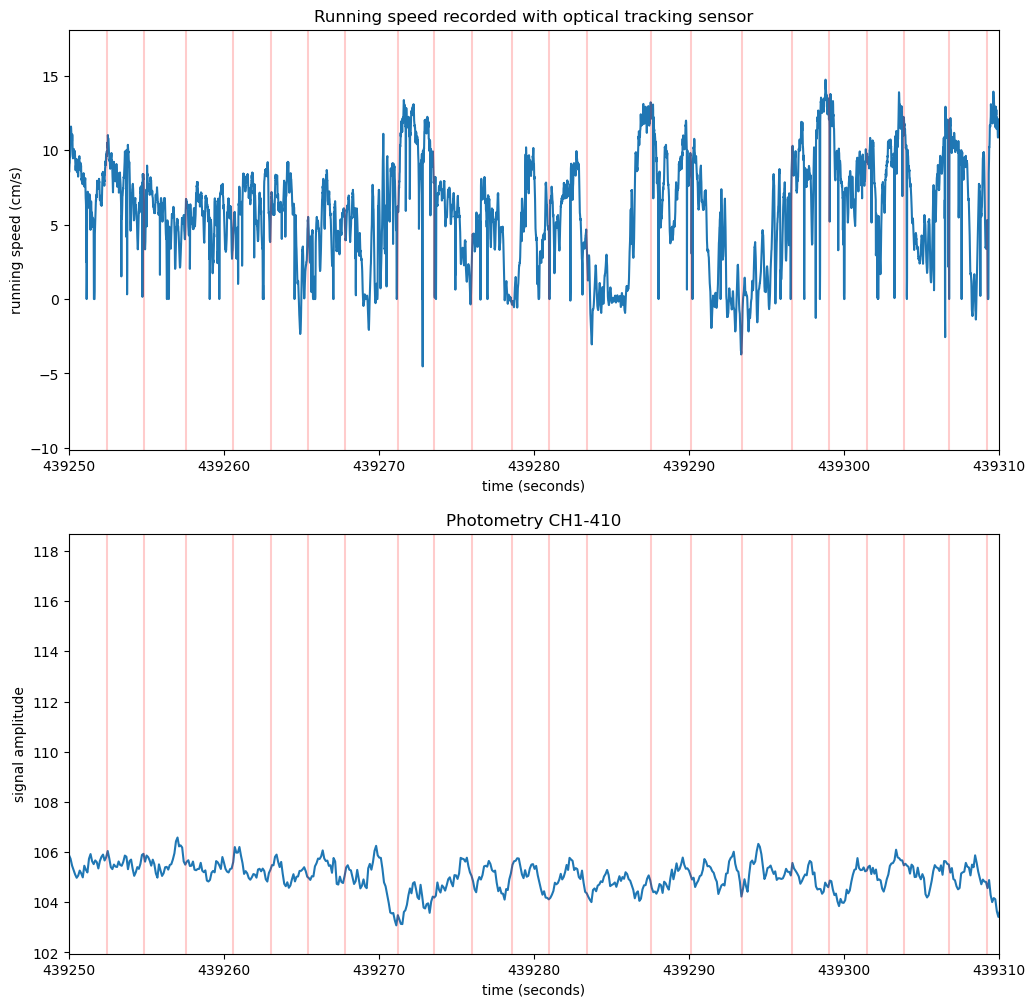

In [18]:
# A = None
# B = None
A = 439250
B = A + 60

plt.figure(figsize=(12,6))
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

stream46_seconds_elapsed = (streams[0]['OpticalTrackingRead0X(46)'].index - harp.REFERENCE_EPOCH).total_seconds()
ax[0].plot(stream46_seconds_elapsed, streams[0]['OpticalTrackingRead0X(46)'] * linear_velocity * 100)
ax[0].set_title('Running speed recorded with optical tracking sensor')
ax[0].set_xlabel('time (seconds)')
ax[0].set_ylabel('running speed (cm/s)')
for halt in halts_applied_at:
    ax[0].axvline(halt, color='r', alpha=0.2)
ax[0].set_xlim([A, B])

photometry_seconds_elapsed = Fluorescence['Seconds'].values
ax[1].plot(photometry_seconds_elapsed, Fluorescence['CH1-470'].values)
ax[1].set_title('Photometry CH1-410')
ax[1].set_xlabel('time (seconds)')
ax[1].set_ylabel('signal amplitude')
for halt in halts_applied_at:
    ax[1].axvline(halt, color='r', alpha=0.2)
ax[1].set_xlim([A, B])

plt.show()

## Loading photodiode and clock signal

In [19]:
photo_diode = utils.read_photodiode(data_path)
clock = utils.read_clock(data_path)
print(photo_diode.shape)
print(clock.shape)

(1917261, 12, 100)
(766904400,)


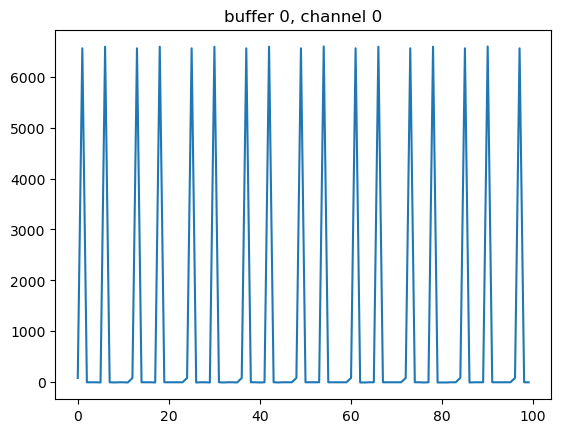

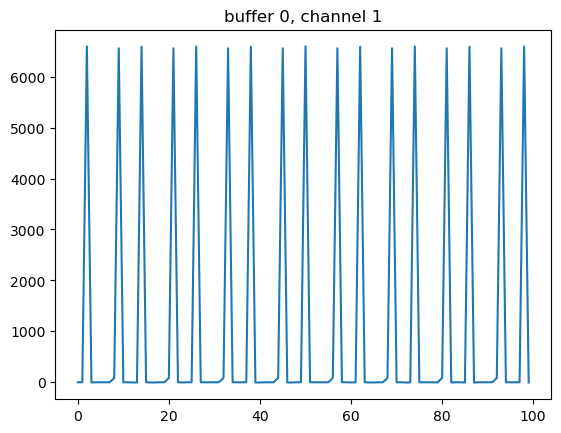

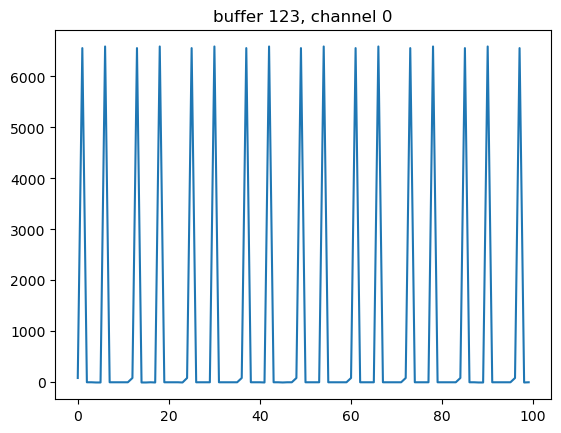

In [20]:
plt.plot(photo_diode[0,0,:])
plt.title('buffer 0, channel 0')
plt.show()

plt.plot(photo_diode[0,1,:])
plt.title('buffer 0, channel 1')
plt.show()

plt.plot(photo_diode[123,0,:])
plt.title('buffer 123, channel 0')
plt.show()

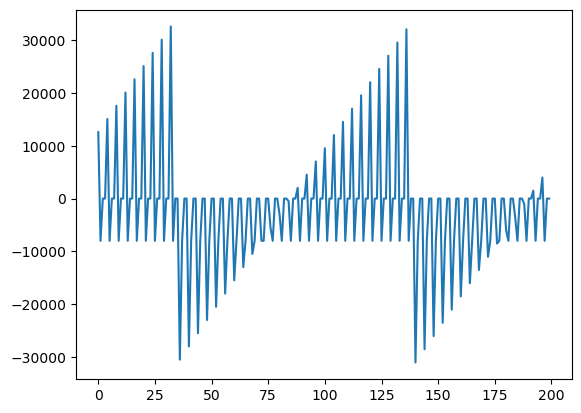

In [23]:
plt.plot(clock[:200])
plt.show()